<a href="https://colab.research.google.com/github/AshwinUnnikrishnan/DeepLearning7150/blob/main/HW3/HW3_1_Classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This can be [run on Google Colab using this link](https://colab.research.google.com/github/CS7150/CS7150-Homework-3/blob/main/HW3.1-Classifiers.ipynb)

## MNIST Classifiers (Convolutional Neural Networks and Fully Connected Networks)

<b>Optional</b>: Installing Wandb to see cool analysis of you code. You can go through the documentation here. We will do it for this assignment to get a taste of the GPU and CPU utilizations. If this is creating problems to your code, please comment out all the wandb lines from the notebook 

In [1]:
# Uncomment the below line to install wandb (optinal)
!pip install wandb 
# Uncomment the below line to install torchinfo (https://github.com/TylerYep/torchinfo) [Mandatory]
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 31.3 MB/s 
     |████████████████████████████████| 182 kB 72.0 MB/s 
     |████████████████████████████████| 162 kB 72.9 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
     |████████████████████████████████| 162 kB 73.0 MB/s 
     |████████████████████████████████| 158 kB 75.2 MB/s 
     |████████████████████████████████| 157 kB 78.7 MB/s 
     |████████████████████████████████| 157 kB 77.1 MB/s 
     |████████████████████████████████| 157 kB 24.6 MB/s 
     |████████████████████████████████| 157 kB 78.2 MB/s 
     |████████████████████████████████| 157 kB 76.8 MB/s 
     |████████████████████████████████| 157 kB 80.2 MB/s 
     |████████████████████████████████| 157 kB 77.7 MB/s 
     |████████████████████████████████| 156 kB 78.7 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=1

In [2]:
%%bash

wget -N https://cs7150.baulab.info/2022-Fall/data/mnist-classify.pth

--2022-10-08 03:50:00--  https://cs7150.baulab.info/2022-Fall/data/mnist-classify.pth
Resolving cs7150.baulab.info (cs7150.baulab.info)... 35.232.255.106
Connecting to cs7150.baulab.info (cs7150.baulab.info)|35.232.255.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1078198 (1.0M)
Saving to: ‘mnist-classify.pth’

     0K .......... .......... .......... .......... ..........  4%  123K 8s
    50K .......... .......... .......... .......... ..........  9%  245K 6s
   100K .......... .......... .......... .......... .......... 14% 5.07M 4s
   150K .......... .......... .......... .......... .......... 18%  255K 3s
   200K .......... .......... .......... .......... .......... 23% 5.47M 3s
   250K .......... .......... .......... .......... .......... 28% 5.91M 2s
   300K .......... .......... .......... .......... .......... 33% 4.41M 2s
   350K .......... .......... .......... .......... .......... 37% 3.65M 1s
   400K .......... .......... .......... ......

In [3]:
# Importing libraries
import matplotlib.pyplot as plt

import torch 
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split,Subset
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary
import numpy as np
import datetime

from typing import List
from collections import OrderedDict
import math

In [4]:
# Create an account at https://wandb.ai/site and paste the api key here (optional)
import wandb
wandb.init(project="hw3.1-ConvNets")

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## Parameters Changes

### Some helper functions to view network parameters

In [5]:
def view_network_parameters(model):
    # Visualise the number of parameters
    tensor_list = list(model.state_dict().items())
    total_parameters = 0
    print('Model Summary\n')
    for layer_tensor_name, tensor in tensor_list:
        total_parameters += int(torch.numel(tensor))
        print('{}: {} elements'.format(layer_tensor_name, torch.numel(tensor)))
    print(f'\nTotal Trainable Parameters: {total_parameters}!')

In [6]:
def view_network_shapes(model, input_shape):
    print(summary(conv_net, input_size=input_shape))

### Fully Connected Network for Image Classification
Let's build a simple fully connected network!

In [7]:
def simple_fc_net():
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(1*28*28,8*28*28),
        nn.ReLU(),
        nn.Linear(8*28*28,16*14*14),
        nn.ReLU(),
        nn.Linear(16*14*14,32*7*7),
        nn.ReLU(),
        nn.Linear(32*7*7,288),
        nn.ReLU(),
        nn.Linear(288,64),
        nn.ReLU(),
        nn.Linear(64,10),
        nn.LogSoftmax())
    return model

In [8]:
fc_net = simple_fc_net()

In [9]:
view_network_parameters(fc_net)

Model Summary

1.weight: 4917248 elements
1.bias: 6272 elements
3.weight: 19668992 elements
3.bias: 3136 elements
5.weight: 4917248 elements
5.bias: 1568 elements
7.weight: 451584 elements
7.bias: 288 elements
9.weight: 18432 elements
9.bias: 64 elements
11.weight: 640 elements
11.bias: 10 elements

Total Trainable Parameters: 29985482!


In [10]:
from torchinfo import summary
summary(fc_net, input_size=(1, 1, 28,28))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Flatten: 1-1                           [1, 784]                  --
├─Linear: 1-2                            [1, 6272]                 4,923,520
├─ReLU: 1-3                              [1, 6272]                 --
├─Linear: 1-4                            [1, 3136]                 19,672,128
├─ReLU: 1-5                              [1, 3136]                 --
├─Linear: 1-6                            [1, 1568]                 4,918,816
├─ReLU: 1-7                              [1, 1568]                 --
├─Linear: 1-8                            [1, 288]                  451,872
├─ReLU: 1-9                              [1, 288]                  --
├─Linear: 1-10                           [1, 64]                   18,496
├─ReLU: 1-11                             [1, 64]                   --
├─Linear: 1-12                           [1, 10]      

<b>Exercise</b>: Now try to add different layers and see how the network parameters vary. Does adding layers reduce the parameters? Does the number of hidden neurons in the layers affect the total trainable parameters? 

<i>Add a few sentences on your observations while using various architectures</i>

In [11]:
def getParameters(fc_net):
  return summary(fc_net, input_size=(1, 1, 28,28))

### Linear Layer at the end 

In [12]:
def simple_fc_net_add_Linear():
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(1*28*28,8*28*28),
        nn.ReLU(),
        nn.Linear(8*28*28,16*14*14),
        nn.ReLU(),
        nn.Linear(16*14*14,32*7*7),
        nn.ReLU(),
        nn.Linear(32*7*7,288),
        nn.ReLU(),
        nn.Linear(288,64),
        nn.ReLU(),
        nn.Linear(64,32),
        nn.ReLU(),
        nn.Linear(32,10),
        nn.LogSoftmax())
    return model


In [13]:
getParameters(simple_fc_net_add_Linear())

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Flatten: 1-1                           [1, 784]                  --
├─Linear: 1-2                            [1, 6272]                 4,923,520
├─ReLU: 1-3                              [1, 6272]                 --
├─Linear: 1-4                            [1, 3136]                 19,672,128
├─ReLU: 1-5                              [1, 3136]                 --
├─Linear: 1-6                            [1, 1568]                 4,918,816
├─ReLU: 1-7                              [1, 1568]                 --
├─Linear: 1-8                            [1, 288]                  451,872
├─ReLU: 1-9                              [1, 288]                  --
├─Linear: 1-10                           [1, 64]                   18,496
├─ReLU: 1-11                             [1, 64]                   --
├─Linear: 1-12                           [1, 32]      

### Linear Layer at the beginning

In [14]:
def simple_fc_net_Early_Linear():
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(1*28*28,8*28*28),
        nn.ReLU(),
        nn.Linear(8*28*28,4*28*28),
        nn.ReLU(),
        nn.Linear(4*28*28,16*14*14),
        nn.ReLU(),
        nn.Linear(16*14*14,32*7*7),
        nn.ReLU(),
        nn.Linear(32*7*7,288),
        nn.ReLU(),
        nn.Linear(288,64),
        nn.ReLU(),
        nn.Linear(64,10),
        nn.LogSoftmax())
    return model

In [15]:
getParameters(simple_fc_net_Early_Linear())

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Flatten: 1-1                           [1, 784]                  --
├─Linear: 1-2                            [1, 6272]                 4,923,520
├─ReLU: 1-3                              [1, 6272]                 --
├─Linear: 1-4                            [1, 3136]                 19,672,128
├─ReLU: 1-5                              [1, 3136]                 --
├─Linear: 1-6                            [1, 3136]                 9,837,632
├─ReLU: 1-7                              [1, 3136]                 --
├─Linear: 1-8                            [1, 1568]                 4,918,816
├─ReLU: 1-9                              [1, 1568]                 --
├─Linear: 1-10                           [1, 288]                  451,872
├─ReLU: 1-11                             [1, 288]                  --
├─Linear: 1-12                           [1, 64]   

### Removing ReLu from previous

In [16]:
def simple_fc_net_ReLuRemoved():
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(1*28*28,8*28*28),
        nn.ReLU(),
        nn.Linear(8*28*28,4*28*28),
        nn.ReLU(),
        nn.Linear(4*28*28,16*14*14),
        nn.ReLU(),
        nn.Linear(16*14*14,32*7*7),
        nn.ReLU(),
        nn.Linear(32*7*7,288),
        nn.ReLU(),
        nn.Linear(288,64),
        nn.Linear(64,10),
        nn.LogSoftmax())
    return model
getParameters(simple_fc_net_ReLuRemoved())

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Flatten: 1-1                           [1, 784]                  --
├─Linear: 1-2                            [1, 6272]                 4,923,520
├─ReLU: 1-3                              [1, 6272]                 --
├─Linear: 1-4                            [1, 3136]                 19,672,128
├─ReLU: 1-5                              [1, 3136]                 --
├─Linear: 1-6                            [1, 3136]                 9,837,632
├─ReLU: 1-7                              [1, 3136]                 --
├─Linear: 1-8                            [1, 1568]                 4,918,816
├─ReLU: 1-9                              [1, 1568]                 --
├─Linear: 1-10                           [1, 288]                  451,872
├─ReLU: 1-11                             [1, 288]                  --
├─Linear: 1-12                           [1, 64]   

### Bias

In [17]:
def simple_fc_net_BiasAdding():
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(1*28*28,8*28*28),
        nn.ReLU(),
        nn.Linear(8*28*28,4*28*28, bias=True),
        nn.ReLU(),
        nn.Linear(4*28*28,16*14*14, bias=False),
        nn.ReLU(),
        nn.Linear(16*14*14,32*7*7),
        nn.ReLU(),
        nn.Linear(32*7*7,288),
        nn.ReLU(),
        nn.Linear(288,64),
        nn.Linear(64,10),
        nn.LogSoftmax())
    return model
getParameters(simple_fc_net_BiasAdding())

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Flatten: 1-1                           [1, 784]                  --
├─Linear: 1-2                            [1, 6272]                 4,923,520
├─ReLU: 1-3                              [1, 6272]                 --
├─Linear: 1-4                            [1, 3136]                 19,672,128
├─ReLU: 1-5                              [1, 3136]                 --
├─Linear: 1-6                            [1, 3136]                 9,834,496
├─ReLU: 1-7                              [1, 3136]                 --
├─Linear: 1-8                            [1, 1568]                 4,918,816
├─ReLU: 1-9                              [1, 1568]                 --
├─Linear: 1-10                           [1, 288]                  451,872
├─ReLU: 1-11                             [1, 288]                  --
├─Linear: 1-12                           [1, 64]   

In [18]:
# Trainable parameters depends on the input and output of a particular layer, if the values are high then we have large number of parameters that
# we can train to understand the features.
# And we can see that removing or adding an activation function doesnt increase or decrease the trainable parameters, becase ReLu or any other activation
# function is just used to normalize or make data non linear based on already fixed function.
# Bias also has an effect on the learned parameters, we also learn the bias. When the bias is set as false it reduces the number of parameters to learn.
# By default the bias is True.


## CNN for Image Classification

### Convolutional Neural Network for Image Classification
Let's build a simple CNN to classify our images. 
<b> Exercise 3.1.1:</b> In the function below please add the conv/Relu/Maxpool layers to match the shape of FC-Net. Suppose at the some layer the FC-Net has `28*28*16` dimension, we want your conv_net to have `16 X 28 X 28` shape at the same numbered layer. <br>
<b>Extra-credit:</b> Try not to use MaxPool2d !

In [19]:
def simple_conv_net():
    model = nn.Sequential(
        nn.Conv2d(1,16,kernel_size=3,padding=1),
        nn.ReLU(),
        #nn.MaxPool2d(2,2),
        # TO-DO: Add layers below
        
        # TO-DO, what will your shape be after you flatten? Fill it in place of None
        nn.Flatten(),
        nn.Linear(16*28*28,64),
        # Do not change the code below
        nn.ReLU(),
        nn.Linear(64,10),
        nn.LogSoftmax())
    return model

In [20]:
conv_net = simple_conv_net()

In [21]:
view_network_parameters(conv_net)

Model Summary

0.weight: 144 elements
0.bias: 16 elements
3.weight: 802816 elements
3.bias: 64 elements
5.weight: 640 elements
5.bias: 10 elements

Total Trainable Parameters: 803690!


In [22]:
view_network_shapes(conv_net, input_shape=(1,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 16, 28, 28]           160
├─ReLU: 1-2                              [1, 16, 28, 28]           --
├─Flatten: 1-3                           [1, 12544]                --
├─Linear: 1-4                            [1, 64]                   802,880
├─ReLU: 1-5                              [1, 64]                   --
├─Linear: 1-6                            [1, 10]                   650
├─LogSoftmax: 1-7                        [1, 10]                   --
Total params: 803,690
Trainable params: 803,690
Non-trainable params: 0
Total mult-adds (M): 0.93
Input size (MB): 0.00
Forward/backward pass size (MB): 0.10
Params size (MB): 3.21
Estimated Total Size (MB): 3.32


<b>Exercise 3.1.2</b>: Why is the final layer a log softmax? What is a softmax function? Can we use ReLU instead of softmax? If yes, what would you do different? If not, tell us why. If you think there is a different answer, feel free to use this space to chart it down

* Softmax is normally used in the final layer of a neural network. It provides a probablity of an outcome with respect to the other outcomes it can have ( all the evenets are dependent ) and sum of all the probabilities of an even add upto 1. Where as ReLu just tries not to forward negative values, for all negative values the activation function results in 0.
* Fromula
  * ReLu = 0 for x<=0 and x for x>0
  * Softmax = $\frac{e^{-z_i}}{\sum_{k} e^{-z_k}}$
  
  You can see that the Softmax is related to other events and is probability of an even happening considering other events. So in such case it is better than other probability output activation functions like sigmoid where the sum of probabilities of the output does not result in 1 and mutiple classes can have high probabilities unlike softmax.
  
* ReLu can be used in the last layer where we want a positive output, example stock predictions, but it would not give us the most optimal solutions, or for binary classifications where we get non zero value for one type of class and 0 for another class. But problem here is we would not have a confidence level to say how confidently the neural network predicts it.

<b>Exercise 3.1.3</b>: What is the ratio of number of parameters of Conv-net to number of parameters of FC-Net <br>
$\frac{p_{conv-net}}{p_{fc-net}}$ = $\frac{803690}{31819978}$ <br>

Do you see the difference ?! 
Yes, in fc(fully connected) net all the nodes in the hidden layer are interconnected, but in conv-net, not all the nodes are connected to one another in alternate layers. Hence we see that Conv-net has less number of trainable parameters than fc-net, but that does not mean that one is better than the other.

<b>Exercise 3.1.4</b>: Now try to add different layers and see how the network parameters vary. Does adding layers reduce the parameters? Does the number of hidden neurons in the layers affect the total trainable parameters? Use the `build_custom_fc_net` function given below. You do not have to understand the working of it. 

* <i> Adding layers increases trainable parameters and removing decreases. </i>
* <i> Yes the number of neurons in the hidden layer has an effect in the trainable parameters, no. of neurons are directly proportional to the trainable parameters. </i>
* <i> </i>
* <i> </i>

In [23]:
from functools import reduce
import operator
def build_custom_fc_net(inp_dim: int, out_dim: int, hidden_fc_dim: List[int]):
    '''
    Inputs :
    
    inp_dim: Shape of the input dimensions (in MNIST case 28*28)
    out_dim: Desired classification classes (in MNIST case 10)
    hidden_fc_dim: List of the intermediate dimension shapes (list of integers). Try different values and see the shapes'
    
    Return: nn.Sequential (final custom model)
    '''
    assert type(hidden_fc_dim) == list, "Please define hidden_fc_dim as list of integers"
    layers = []
    layers.append((f'flatten', nn.Flatten()))
    # If no hidden layer is required
    if len(hidden_fc_dim) == 0:
        layers.append((f'linear',nn.Linear(math.prod(inp_dim),out_dim)))
        layers.append((f'activation',nn.LogSoftmax()))
    else:
        # Loop over hidden dimensions and add layers
        for idx, dim in enumerate(hidden_fc_dim):
            if idx == 0:

                layers.append((f'linear_{idx+1}',nn.Linear(reduce(operator.mul, inp_dim),dim)))
                layers.append((f'activation_{idx+1}',nn.ReLU()))
            else:
                layers.append((f'linear_{idx+1}',nn.Linear(hidden_fc_dim[idx-1],dim)))
                layers.append((f'activation_{idx+1}',nn.ReLU()))
        layers.append((f'linear_{idx+2}',nn.Linear(dim,out_dim)))
        layers.append((f'activation_{idx+2}',nn.LogSoftmax()))
        
    model =  nn.Sequential(OrderedDict(layers))
    return model

# TO-DO build different networks (atleast 3) and see the parameters
#(You don't have to understand the function above. It is a generic way to build a FC-Net)


fc_net_custom1 = build_custom_fc_net(inp_dim=(1,28,28), out_dim=10, hidden_fc_dim=[128,64,32])
view_network_parameters(fc_net_custom1)
fc_net_custom1 = build_custom_fc_net(inp_dim=(1,28,28), out_dim=10, hidden_fc_dim=[85,64,32])
view_network_parameters(fc_net_custom1)
fc_net_custom2 = build_custom_fc_net(inp_dim=(1,28,28), out_dim=10, hidden_fc_dim=[64,32])
view_network_parameters(fc_net_custom2)

fc_net_custom3 = build_custom_fc_net(inp_dim=(1,28,28), out_dim=10, hidden_fc_dim=[256,128,64,32])
view_network_parameters(fc_net_custom3)

Model Summary

linear_1.weight: 100352 elements
linear_1.bias: 128 elements
linear_2.weight: 8192 elements
linear_2.bias: 64 elements
linear_3.weight: 2048 elements
linear_3.bias: 32 elements
linear_4.weight: 320 elements
linear_4.bias: 10 elements

Total Trainable Parameters: 111146!
Model Summary

linear_1.weight: 66640 elements
linear_1.bias: 85 elements
linear_2.weight: 5440 elements
linear_2.bias: 64 elements
linear_3.weight: 2048 elements
linear_3.bias: 32 elements
linear_4.weight: 320 elements
linear_4.bias: 10 elements

Total Trainable Parameters: 74639!
Model Summary

linear_1.weight: 50176 elements
linear_1.bias: 64 elements
linear_2.weight: 2048 elements
linear_2.bias: 32 elements
linear_3.weight: 320 elements
linear_3.bias: 10 elements

Total Trainable Parameters: 52650!
Model Summary

linear_1.weight: 200704 elements
linear_1.bias: 256 elements
linear_2.weight: 32768 elements
linear_2.bias: 128 elements
linear_3.weight: 8192 elements
linear_3.bias: 64 elements
linear_4.wei

**Decreasing the Hidden layer reduced the number of trainable parameters, and increasing the hidden layer increased the trainable parameters. This was seen earlier as well in our first experiment during parameter changes.**

## Let's train the models to see their performace

In [24]:
# downloading mnist into folder
data_dir = 'data' # make sure that this folder is created in your working dir
# transform the PIL images to tensor using torchvision.transform.toTensor method
train_data = torchvision.datasets.MNIST(data_dir, train=True, download=True, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor()]))
test_data  = torchvision.datasets.MNIST(data_dir, train=False, download=True, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor()]))
print(f'Datatype of the dataset object: {type(train_data)}')
# check the length of dataset
n_train_samples = len(train_data)
print(f'Number of samples in training data: {len(train_data)}')
print(f'Number of samples in test data: {len(test_data)}')
# Check the format of dataset
#print(f'Foramt of the dataset: \n {train_data}')

val_split = .2
batch_size=256 

train_data_, val_data = random_split(train_data, [int(n_train_samples*(1-val_split)), int(n_train_samples*val_split)])

train_loader = torch.utils.data.DataLoader(train_data_, batch_size=batch_size,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Datatype of the dataset object: <class 'torchvision.datasets.mnist.MNIST'>
Number of samples in training data: 60000
Number of samples in test data: 10000


### Displaying the loaded dataset

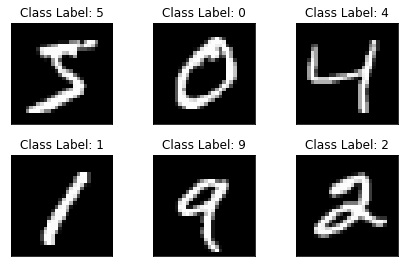

In [25]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2, 3, i+1)
  plt.tight_layout()
  plt.imshow(train_data[i][0][0], cmap='gray', interpolation='none')
  plt.title("Class Label: {}".format(train_data[i][1]))
  plt.xticks([])
  plt.yticks([])


## Function to train the model

In [26]:
def train_model(model, train_loader, device, loss_fn, optimizer, input_dim=(-1,1,28,28)):
    model.train()
    # Initiate a loss monitor
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning and not supervised classification)
    for images, labels in train_loader: # the variable `labels` will be used for customised training
        # reshape input
        images = torch.reshape(images,input_dim)
        images = images.to(device)
        labels = labels.to(device)
        # predict the class
        predicted = model(images)
        loss = loss_fn(predicted, labels)
        # Backward pass (back propagation)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()       
        wandb.log({"Training Loss": loss})
        wandb.watch(model)
        train_loss.append(loss.detach().cpu().numpy())
    return np.mean(train_loss)

## Function to test the model

In [27]:
# Testing Function
def test_model(model, test_loader, device, loss_fn, input_dim=(-1,1,28,28)):
    # Set evaluation mode for encoder and decoder
    model.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        predicted = []
        actual = []
        for images, labels in test_loader:
            # reshape input
            images = torch.reshape(images,input_dim)
            images = images.to(device)
            labels = labels.to(device)
            ## predict the label
            pred = model(images)
            # Append the network output and the original image to the lists
            predicted.append(pred.cpu())
            actual.append(labels.cpu())
        # Create a single tensor with all the values in the lists
        predicted = torch.cat(predicted)
        actual = torch.cat(actual) 
        # Evaluate global loss
        val_loss = loss_fn(predicted, actual)
    return val_loss.data

Before we start training let's delete the huge FC-Net we built and build a reasonable FC-Net (You learnt why such larger networks are not reasonable in the previous notebook)

In [28]:
del fc_net_custom1, fc_net_custom2, fc_net_custom3
torch.cuda.empty_cache()
# Building a reasonable fully connected network
fc_net = build_custom_fc_net(inp_dim=(1,28,28), out_dim=10, hidden_fc_dim=[128,64,32])

<b>Exercise 3.1.5:</b> 
Code the `weight_init_xavier` function by referring to https://pytorch.org/docs/stable/nn.init.html. Replace the weight initializations to your own function.


In [29]:
import random

### Set the random seed for reproducible results
torch.manual_seed(0)
# Choosing a device based on the env and torch setup
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

def weight_init_zero(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        torch.nn.init.constant_(m.weight, 0.0)
        m.bias.data.fill_(0.01)

def weight_init_xavier(m):
  '''
  TO-DO: please add code below to add xavier uniform initialization and remove the 'pass'
  
  '''
  if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):

    if isinstance(m, nn.Linear):
      input, output = m.in_features, m.out_features
    else:
      input, output = m.in_channels, m.out_channels
    val = random.uniform(-(math.sqrt(6)/math.sqrt(input+output)),(math.sqrt(6)/math.sqrt(input+output)))
    torch.nn.init.constant_(m.weight, val)
    
fc_net.to(device)
conv_net.to(device)

# Apply the weight initialization
fc_net.apply(weight_init_zero)
conv_net.apply(weight_init_zero)

# Apply the xavier weight initialization
#TO-DO: Add your function here
fc_net.apply(weight_init_xavier)
conv_net.apply(weight_init_xavier)


# Take the parameters for optimiser
params_to_optimize_fc = [
    {'params': fc_net.parameters()}
]

params_to_optimize_conv = [
    {'params': conv_net.parameters()}
]
### Define the loss function
loss_fn = torch.nn.NLLLoss()
### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

optim_fc = torch.optim.Adam(params_to_optimize_fc, lr=lr, weight_decay=1e-05)
optim_conv = torch.optim.Adam(params_to_optimize_conv, lr=lr, weight_decay=1e-05)
num_epochs = 30
wandb.config = {
  "learning_rate": lr,
  "epochs": num_epochs,
  "batch_size": batch_size
}

Selected device: cuda


# Training the Convolutional Neural Networks

In [36]:
print('Conv Net training started')
history_conv = {'train_loss':[],'val_loss':[]}
start_time = datetime.datetime.now()

for epoch in range(num_epochs):
    ### Training 
    
    train_loss = train_model(
        model=conv_net,
        train_loader=train_loader,
        device=device,
        loss_fn=loss_fn,
        optimizer=optim_conv,
        input_dim=(-1,1,28,28))
    ### Validation  (use the testing function)
    val_loss = test_model(
        model=conv_net,
        test_loader=test_loader,
        device=device,
        loss_fn=loss_fn,
        input_dim=(-1,1,28,28))
    # Print Losses 
    print(f'Epoch {epoch+1}/{num_epochs} : train loss {train_loss:.3f} \t val loss {val_loss:.3f}')
    history_conv['train_loss'].append(train_loss)
    history_conv['val_loss'].append(val_loss)
    
    
print(f'Conv Net training done in {(datetime.datetime.now()-start_time).total_seconds():.3f} seconds!')

Conv Net training started
Epoch 1/30 : train loss 1.611 	 val loss 1.570
Epoch 2/30 : train loss 1.541 	 val loss 1.564
Epoch 3/30 : train loss 1.527 	 val loss 1.543
Epoch 4/30 : train loss 1.518 	 val loss 1.545
Epoch 5/30 : train loss 1.509 	 val loss 1.550
Epoch 6/30 : train loss 1.500 	 val loss 1.535
Epoch 7/30 : train loss 1.497 	 val loss 1.538
Epoch 8/30 : train loss 1.491 	 val loss 1.535
Epoch 9/30 : train loss 1.483 	 val loss 1.529
Epoch 10/30 : train loss 1.482 	 val loss 1.525
Epoch 11/30 : train loss 1.474 	 val loss 1.517
Epoch 12/30 : train loss 1.471 	 val loss 1.523
Epoch 13/30 : train loss 1.470 	 val loss 1.519
Epoch 14/30 : train loss 1.464 	 val loss 1.522
Epoch 15/30 : train loss 1.461 	 val loss 1.520
Epoch 16/30 : train loss 1.459 	 val loss 1.514
Epoch 17/30 : train loss 1.455 	 val loss 1.515
Epoch 18/30 : train loss 1.454 	 val loss 1.514
Epoch 19/30 : train loss 1.445 	 val loss 1.523
Epoch 20/30 : train loss 1.452 	 val loss 1.518
Epoch 21/30 : train los

### Visualizing Training Progress of Conv Net (Also check out your wandb.ai homepage)

Text(0, 0.5, 'Negative Log Likelihood Loss')

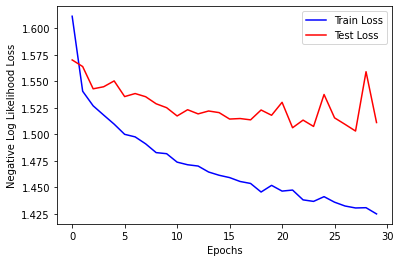

In [37]:
fig = plt.figure()
plt.plot(history_conv['train_loss'], color='blue')
plt.plot(history_conv['val_loss'], color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Negative Log Likelihood Loss')

### Visualizing Predictions of Conv Net

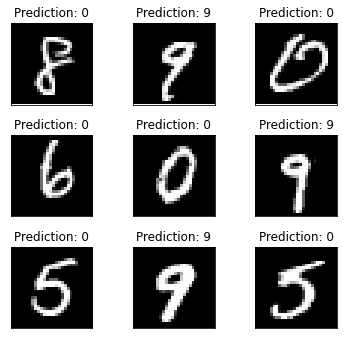

In [38]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
with torch.no_grad():
    example_data = example_data.to(device)
    output = conv_net(example_data)
example_data = example_data.cpu().detach().numpy()
fig = plt.figure(figsize=(5,5))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray',interpolation='none')
    plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
    plt.xticks([])
    plt.yticks([])

# Training the Fully-Connected Neural Networks

<b>Exercise 3.1.6:</b> Train the fully connected neural network and analyse it

In [34]:
#TO-DO:Train the fc_net here
print('FC Net training started')
history_fc = {'train_loss':[],'val_loss':[]}
start_time = datetime.datetime.now()

for epoch in range(num_epochs):
    ### Training 
    
    train_loss = train_model(
        model=fc_net,
        train_loader=train_loader,
        device=device,
        loss_fn=loss_fn,
        optimizer=optim_fc,
        input_dim=(-1,1,28,28))
    ### Validation  (use the testing function)
    val_loss = test_model(
        model=fc_net,
        test_loader=test_loader,
        device=device,
        loss_fn=loss_fn,
        input_dim=(-1,1,28,28))
    # Print Losses 
    print(f'Epoch {epoch+1}/{num_epochs} : train loss {train_loss:.3f} \t val loss {val_loss:.3f}')
    history_fc['train_loss'].append(train_loss)
    history_fc['val_loss'].append(val_loss)
    
    
print(f'FC Net training done in {(datetime.datetime.now()-start_time).total_seconds():.3f} seconds!')

FC Net training started


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch 1/30 : train loss 2.487 	 val loss 2.200
Epoch 2/30 : train loss 2.036 	 val loss 1.969
Epoch 3/30 : train loss 1.929 	 val loss 1.907
Epoch 4/30 : train loss 1.881 	 val loss 1.868
Epoch 5/30 : train loss 1.843 	 val loss 1.837
Epoch 6/30 : train loss 1.815 	 val loss 1.812
Epoch 7/30 : train loss 1.791 	 val loss 1.790
Epoch 8/30 : train loss 1.773 	 val loss 1.780
Epoch 9/30 : train loss 1.756 	 val loss 1.760
Epoch 10/30 : train loss 1.744 	 val loss 1.749
Epoch 11/30 : train loss 1.732 	 val loss 1.736
Epoch 12/30 : train loss 1.721 	 val loss 1.736
Epoch 13/30 : train loss 1.712 	 val loss 1.720
Epoch 14/30 : train loss 1.705 	 val loss 1.714
Epoch 15/30 : train loss 1.698 	 val loss 1.708
Epoch 16/30 : train loss 1.691 	 val loss 1.707
Epoch 17/30 : train loss 1.684 	 val loss 1.693
Epoch 18/30 : train loss 1.679 	 val loss 1.695
Epoch 19/30 : train loss 1.672 	 val loss 1.682
Epoch 20/30 : train loss 1.659 	 val loss 1.666
Epoch 21/30 : train loss 1.643 	 val loss 1.654
E

## Visualizing Training Progress of FC Net (Check out your wandb.ai project webpage)

Text(0, 0.5, 'Negative Log Likelihood Loss')

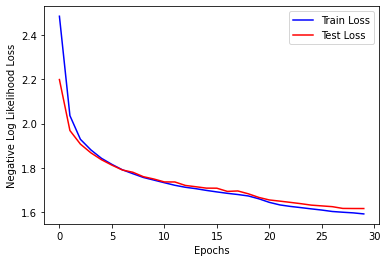

In [41]:
# TODO - Visualize the training progress of fc_net
fig = plt.figure()
plt.plot(history_fc['train_loss'], color='blue')
plt.plot(history_fc['val_loss'], color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Negative Log Likelihood Loss')

## Visualizing Predictions of FC Net

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


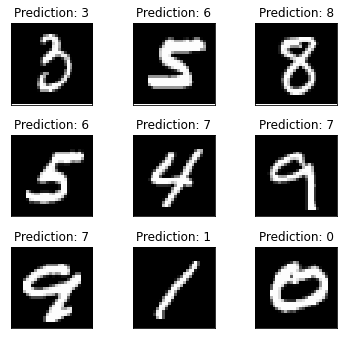

In [42]:
# TODO - Visualise the predictions of fc_net
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
with torch.no_grad():
    example_data = example_data.to(device)
    output = fc_net(example_data)
example_data = example_data.cpu().detach().numpy()
fig = plt.figure(figsize=(5,5))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray',interpolation='none')
    plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
    plt.xticks([])
    plt.yticks([])

<b>Exercise 3.1.7</b>: What are the training times for each of the model? Did both the models take similar times? If yes, why? Shouldn't CNN train faster given it's number of weights to train?

In [35]:
# FC net takes more time than the ConvNet, but not a lot as we would have impression based on the number of trainable parameters.  ConvNet took time = 990 seconds where as FCNet took 1021.772 seconds. 
# This is because there are lot many multiplications happening in the ConvNet at the conv2d, from One channel it gives output of 16 channels so those many multiplications happen with kernel which
# is of size 3*3.

In [43]:
'''
The convolution operation are much more complex than dense layer. Convolution is the process of adding each element of the image to its local neighbors, weighted by the kernel. 
Every convolution is essentially a multiple nested loop. 
'''

'\nThe convolution operation are much more complex than dense layer. Convolution is the process of adding each element of the image to its local neighbors, weighted by the kernel. \nEvery convolution is essentially a multiple nested loop. \n'

## Let's see how the models perform under translation

In principle, one of the advantages of convolutions is that they are equivariant under translation which means that a function composed out of convolutions should invariant under translation.

<b>Exercise 3.1.8</b>: In practice, however, we might not see perfect invariance under translation.  What aspect of our network leads to imperfect invariance?

Lets start with what translation Invariance and translation equivariant means
* Translation Invariance : $f(x) = y$ and $f(x-i) = y$
* Translation Equivariant : $f(x) = y$ and $f(x-i) = y-i$

Convolutions are both translation invariant and equivariant, but normally in convolution network the end hidden layers are fully connected layers which leads to imperfect invariance. Example if for 0 we have vertical translation and the bottom part of 0 is cut, in that case it doesnt give correct solution.

We will next measure the sensitivity  of the convolutional network to translation in practice, and we will compare it to the fully-connected version. 

In [44]:
## function to check accuracies for unit translation
def shiftVsAccuracy(model, test_loader, device, loss_fn, shifts = 12, input_dim=(-1,1,28,28)):
    # Set evaluation mode for encoder and decoder
    accuracies = []
    shifted = []
    for i in range(-shifts,shifts):
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad(): # No need to track the gradients
            # Define the lists to store the outputs for each batch
            predicted = []
            actual = []
            for images, labels in test_loader:
                # reshape input
                images = torch.roll(images,shifts=i, dims=2)
                if i == 0:
                    pass
                elif i > 0:
                    images[:,:,:i,:] = 0
                else:
                    images[:,:,i:,:] = 0
                images = torch.reshape(images,input_dim)
                images = images.to(device)
                labels = labels.to(device)
                ## predict the label
                pred = model(images)
                # Append the network output and the original image to the lists
                _ , pred = torch.max(pred.data, 1)
                total += labels.size(0)
                correct += (pred == labels).sum().item()
                predicted.append(pred.cpu())
                actual.append(labels.cpu())  
            shifted.append(images[0][0].cpu())
            acc = 100 * correct // total
            accuracies.append(acc)
    return accuracies,shifted

In [45]:
accuracies,shifted = shiftVsAccuracy(
        model=conv_net,
        test_loader=test_loader,
        device=device,
        shifts=12,
        loss_fn=loss_fn,
        input_dim=(-1,1,28,28))

Text(0.5, 1.0, 'Accuracy Vs Translation')

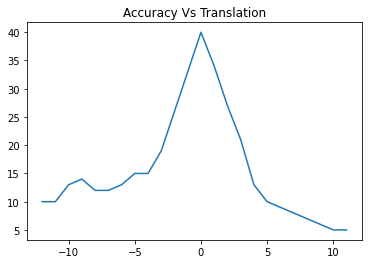

In [46]:
shifts = np.arange(-12,12)
plt.plot(shifts,accuracies)
plt.title('Accuracy Vs Translation')

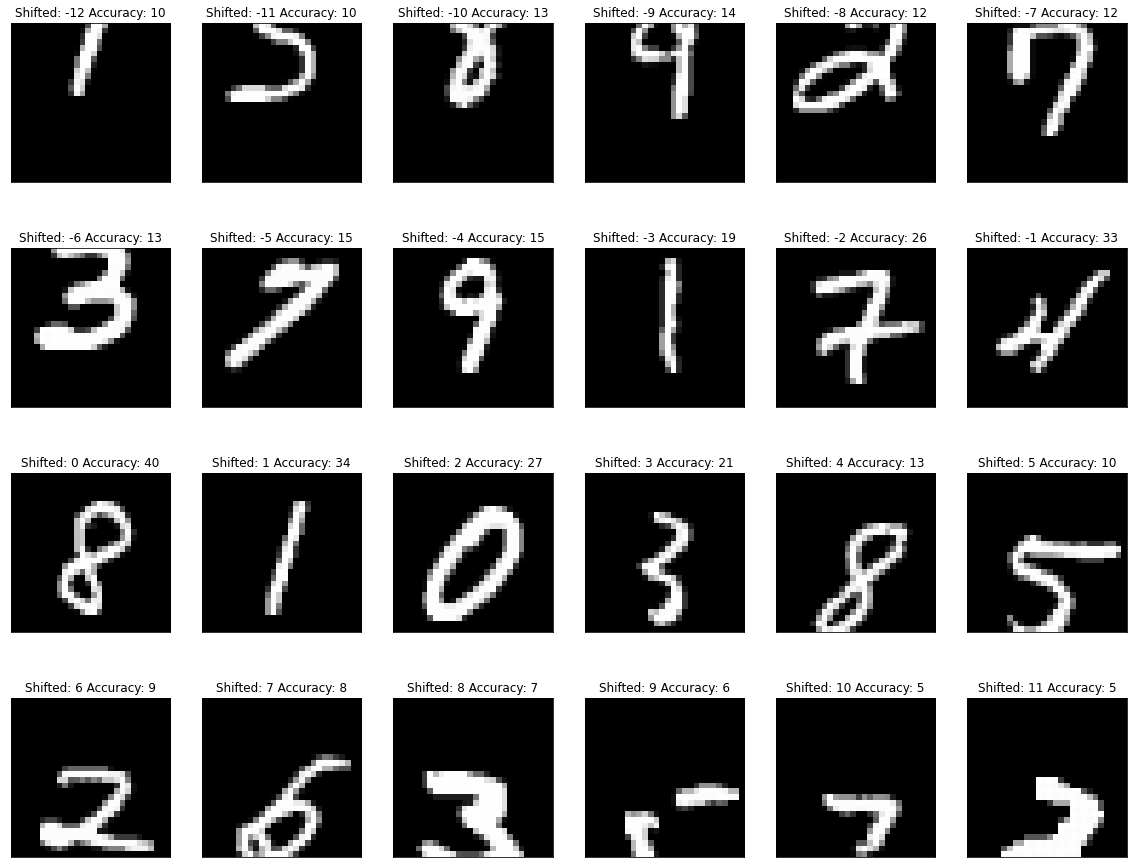

In [47]:
fig = plt.figure(figsize=(20,20))
plt_num = 0
for i in range(-12,12):
    plt.subplot(5,6,plt_num+1)
    plt.imshow(shifted[plt_num], cmap='gray',interpolation='none')
    plt.title(f"Shifted: {i} Accuracy: {accuracies[plt_num]}")
    plt.xticks([])
    plt.yticks([])
    plt_num+=1

In [48]:
accuracies_fc,shifted_fc = shiftVsAccuracy(
        model=fc_net,
        test_loader=test_loader,
        device=device,
        shifts=12,
        loss_fn=loss_fn,
        input_dim=(-1,1,28,28))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Text(0.5, 1.0, 'Accuracy Vs Translation')

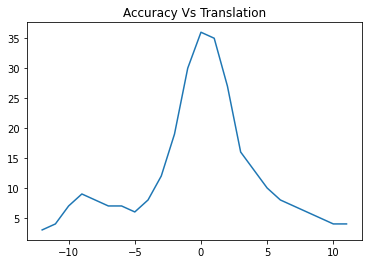

In [50]:
shifts = np.arange(-12,12)
plt.plot(shifts,accuracies_fc)
plt.title('Accuracy Vs Translation')

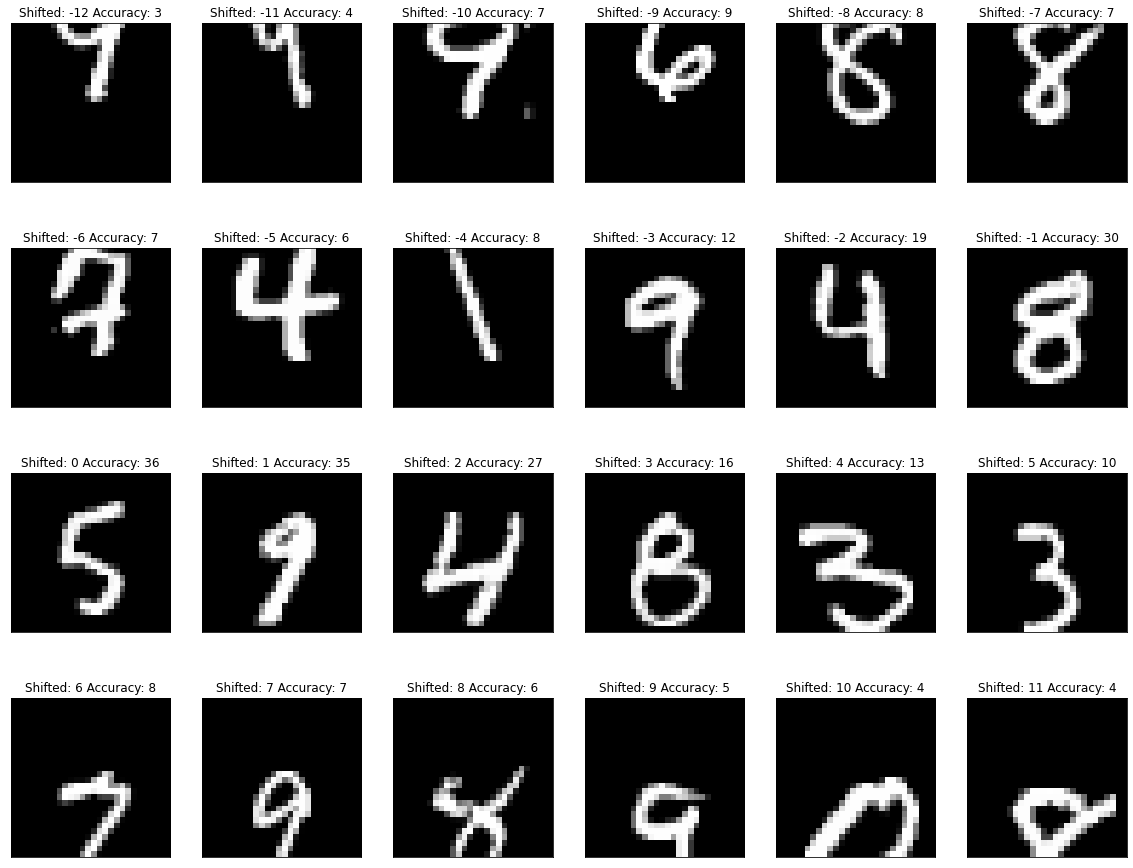

In [51]:
fig = plt.figure(figsize=(20,20))
plt_num = 0
for i in range(-12,12):
    plt.subplot(5,6,plt_num+1)
    plt.imshow(shifted_fc[plt_num], cmap='gray',interpolation='none')
    plt.title(f"Shifted: {i} Accuracy: {accuracies_fc[plt_num]}")
    plt.xticks([])
    plt.yticks([])
    plt_num+=1

<b>Exercise 3.1.8:</b>
Do the same for FC-Net and plot the accuracies. Is the rate of accuracy degradation same as Conv-Net? Can you justify why this happened? <br>
Clue: You might want to look at the way convolution layers process information

In [ ]:
# Because we trained the model for just 30 iterations, the FC has learnt more than convnet, but if we train for more iterations we would be able to see that the accuracy degradation for FCnet
# will be more than convNet, that is because in convNet the convolutions each node is not connected to everyother node in the next layer. This leads to situation where the nodes learn small features in the 
# image. Example if we train 1 with Conv2 it will learn a vertical sobel kernel that will detect or fire when there are straight vertical lines. This leads to translation invariance, it just needs to see 
# some vertical line.

# But in the case of fully connected network, it tries to learn the image as a whole so a small translation that will result in some part of the image getting missed or getting rotated will lead to very
# less accuracy.